# Predict Future Sales

This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition is aimed to work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

The objective is to predict total sales for every product and store in the next month. 

In [96]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# To plot pretty figures
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# import machine learning algorithms
import xgboost as xgb
import lightgbm as lgb

# 1. Import data

In [97]:
# The given five files include the infomation of items(name, item_id, category_id), 
# shop(shop_name, shop_id), item_categories(item_category_name, item_category_id) 
# sales_train(date, date_block_num, shop_id, item_id, item_price, item count_day) and
# test(id, shop_id, item_id)
items  = pd.read_csv('input/items.csv')
train = pd.read_csv('input/sales_train.csv')
test = pd.read_csv('input/test.csv')
item_category = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv('input/shops.csv')

## 1.1 Review items data

In [98]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [99]:
# There are 22170 items in total.
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [100]:
# The number of items dramatically varies for different categories. Some categroies contains more items than others. 
items["item_category_id"].value_counts().head(15)

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
43     471
57     427
56     397
67     394
63     366
Name: item_category_id, dtype: int64

## 1.2 Review item categories data

In [101]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [102]:
# There are 84 categories in total.
item_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


## 1.3 Review shops data

In [103]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [104]:
# There are 60 shops in total.
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


## 1.4 Review train data

In [105]:
# The postive number in item_cnt_day column stands for the nubmer of sales during the day
# while negative number stands for return.
# The date_block_num stands for the month number: 0 stands for Jan 2013, 1 stands for Feb 2013
# and so on and so forth. The range of the month number is between 0 - 33, which means the spreadsheet
# contrains sales data from Jan 2013 to Oct 2015.
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### 1.4.1 Create new train dataset

Since the train table doesn't include the item_name, category and category_id,
we need to combine few tables together.

In [107]:
new_train = pd.merge(train, items, how = 'left', on = 'item_id')
new_train = pd.merge(new_train, item_category, how = 'left', on = 'item_category_id')
new_train = pd.merge(new_train, shops, how = 'left', on = 'shop_id')

In [108]:
new_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


Then we can separate year, month and day from date column. In addition, we can add day of the week, if it is a holiday to the table.

In [109]:
new_train['date'] = pd.to_datetime(new_train.date,format="%d.%m.%Y")
new_train['year'] = new_train['date'].dt.year
new_train['month'] = new_train['date'].dt.month
new_train['day'] = new_train['date'].dt.day
# get day of week, 0 -> Sunday, 1 -> Monday and so forth
new_train['Day_of_week'] = new_train['date'].dt.dayofweek

In [110]:
col = new_train.columns.tolist()[0:1] \
    + new_train.columns.tolist()[-4:] \
    + new_train.columns.tolist()[1:-4]

In [111]:
new_train = new_train[col]

In [112]:
new_train.head()

,date,year,month,day,Day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,2013,1,5,5,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


Let's see how holiday affect the sales.

In [113]:
# !pip install workalendar
from workalendar.europe import Russia
cal = Russia()
new_train['Is_holiday'] = new_train['date'].apply(lambda x: cal.is_holiday(x))
True_False = {True: 1 ,False: 0}
new_train['Is_holiday(binary)'] = new_train['Is_holiday'].apply(lambda x: True_False[x])

In [114]:
# Convert id values to string# Convert id values 
new_train['shop_id']= new_train.shop_id.astype('str')
new_train['item_id']= new_train.item_id.astype('str')

new_train.head()

,date,year,month,day,Day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,Is_holiday,Is_holiday(binary)
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",False,0
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
2,2013-01-05,2013,1,5,5,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",False,0


In [115]:
# Check the size of the training data.
print('Train shape', new_train.shape)

Train shape (2935849, 16)


In [116]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 16 columns):
date                  datetime64[ns]
year                  int64
month                 int64
day                   int64
Day_of_week           int64
date_block_num        int64
shop_id               object
item_id               object
item_price            float64
item_cnt_day          float64
item_name             object
item_category_id      int64
item_category_name    object
shop_name             object
Is_holiday            bool
Is_holiday(binary)    int64
dtypes: bool(1), datetime64[ns](1), float64(2), int64(7), object(5)
memory usage: 361.2+ MB


In [117]:
# the data varies from week to week
new_train['date_block_num'].value_counts().head(15)

11    143246
23    130786
2     121347
0     115690
1     108613
7     104772
6     100548
5     100403
12     99349
10     96736
8      96137
9      94202
3      94109
14     92733
4      91759
Name: date_block_num, dtype: int64

In [118]:
# the data varies from shop to shop
new_train['shop_id'].value_counts().head(15)

31    235636
25    186104
54    143480
28    142234
57    117428
42    109253
27    105366
6      82663
58     71441
56     69573
46     66321
50     65173
19     63911
15     59511
35     58445
Name: shop_id, dtype: int64

In [119]:
# The data varies from item to item. We got 22170 items in item tabel, 
# however, we have 21807 items from train tabel, which means some items
# were never sold or the record were missing.
new_train['item_id'].value_counts().head(15)

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
7856      6602
3732      6475
2308      6320
4870      5811
3734      5805
1855      5681
5821      5389
16787     5283
6675      5122
7894      5107
Name: item_id, dtype: int64

In [120]:
# Generally, the sales of a specific item were less than 5 per shop per day. 
# However, we also see some wholesale examples as well. The occurrences of wholesale 
# were rare.
new_train['item_cnt_day'].value_counts().head(15)

 1.0     2629372
 2.0      194201
 3.0       47350
 4.0       19685
 5.0       10474
-1.0        7252
 6.0        6338
 7.0        4057
 8.0        2903
 9.0        2177
 10.0       1820
 11.0       1263
 12.0       1083
 13.0        918
 14.0        716
Name: item_cnt_day, dtype: int64

In [121]:
# Number of NaNs for each object.No NaNs, good.
new_train.isnull().sum(axis=1).head(15)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

In [122]:
# Number of NaNs for each column. No NaNs, good.
new_train.isnull().sum(axis=0)

date                  0
year                  0
month                 0
day                   0
Day_of_week           0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
Is_holiday            0
Is_holiday(binary)    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ff64e860>,
      dtype=object)

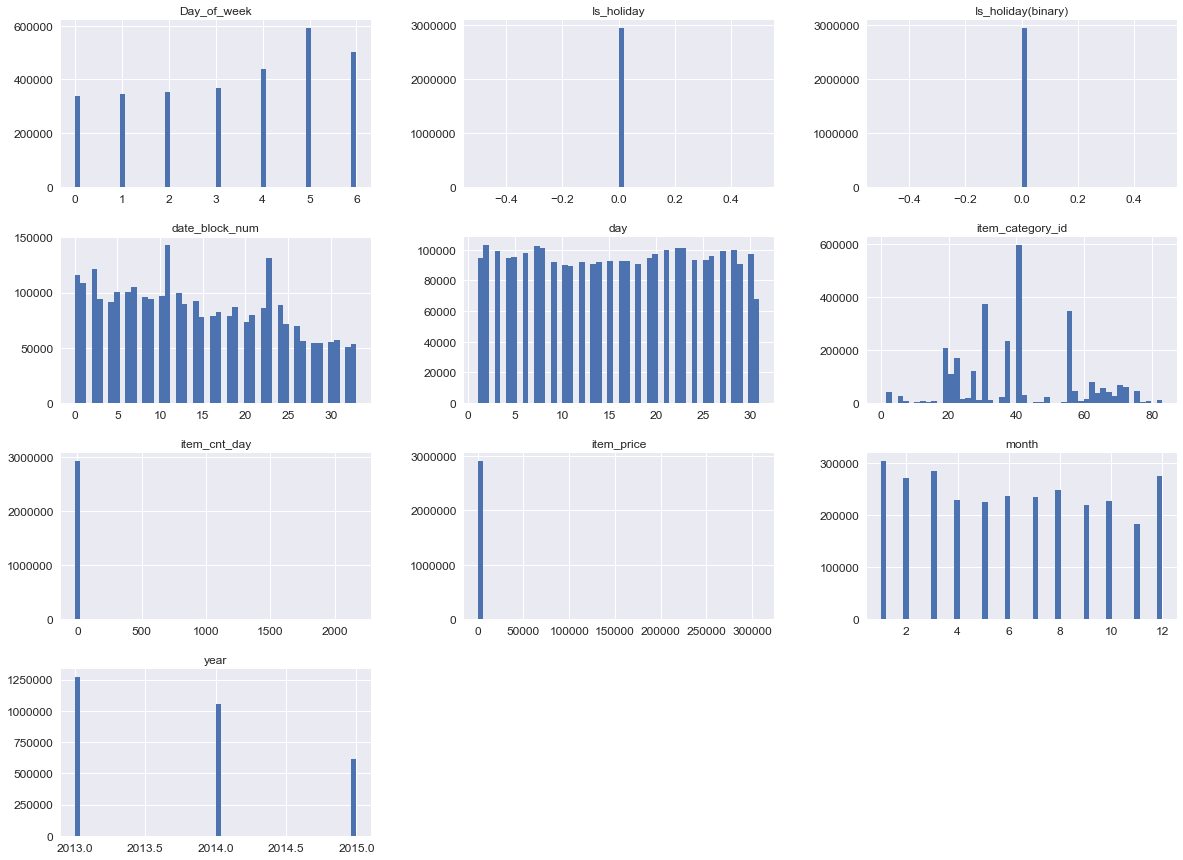

In [123]:
new_train.hist(bins=50, figsize=(20,15))

# 1.5 Review test data

In [124]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [125]:
# we have 5100 records for each shop
test['shop_id'].value_counts().head(15)

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
Name: shop_id, dtype: int64

In [126]:
# we have 42 records for each item
test['item_id'].value_counts().head(15)

2047     42
19744    42
15406    42
13359    42
3240     42
1193     42
7338     42
11436    42
9389     42
21795    42
13231    42
13743    42
3624     42
1577     42
7722     42
Name: item_id, dtype: int64

# 2. Exploratory data analysis

## 2.1 Seasonal sales change analysis

The price of a specific item may change owing to different month. I shall find patterns for items.

In [127]:
new_train.head()

,date,year,month,day,Day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,Is_holiday,Is_holiday(binary)
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",False,0
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
2,2013-01-05,2013,1,5,5,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",False,0


In [128]:
# create a sub dataframe 
df_work = new_train[['year','month','item_id','date_block_num','item_cnt_day']]

In [129]:
df_work.head()

,year,month,item_id,date_block_num,item_cnt_day
0,2013,1,22154,0,1.0
1,2013,1,2552,0,1.0
2,2013,1,2552,0,-1.0
3,2013,1,2554,0,1.0
4,2013,1,2555,0,1.0


In [130]:
grouped_month_sales = df_work.groupby(['date_block_num']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={"item_cnt_day":"item_cnt_month"})

In [131]:
grouped_month_sales.head(10)

,date_block_num,item_cnt_month
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


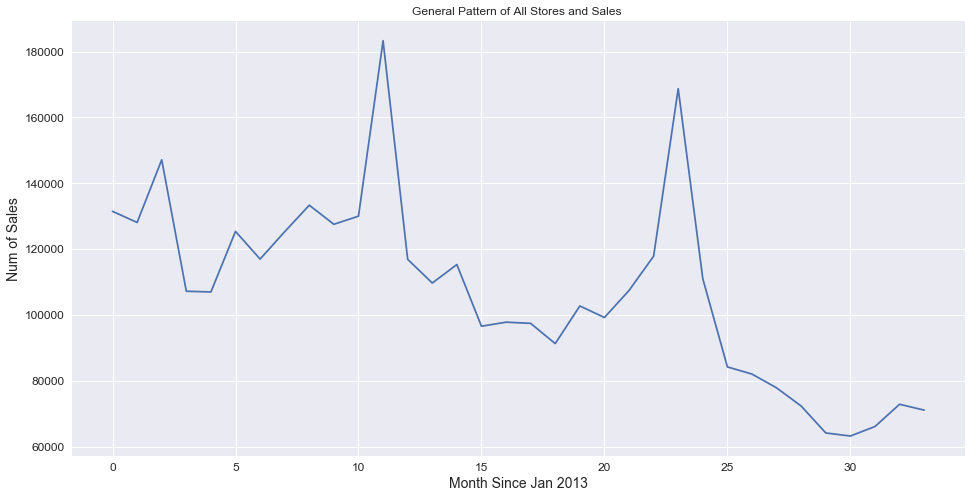

In [132]:
# plot the general pattern of all stores and sales 
plt.figure(figsize=(16,8))
plt.title('General Pattern of All Stores and Sales ')
plt.xlabel('Month Since Jan 2013')
plt.ylabel('Num of Sales')
plt.plot(grouped_month_sales['date_block_num'],grouped_month_sales['item_cnt_month']);

We can see the overall pattern of sales in all stores. 

We have the following discoveries:
1. The overall sales in 2015 is lower than previous two years.

2. The sales in Nov(11 and 23 in x-axis on the graph) reached the peak of the year. We expected the similar patthern in 2015.

Let's see a specific item sales over years.

In [133]:
df_work.head()

,year,month,item_id,date_block_num,item_cnt_day
0,2013,1,22154,0,1.0
1,2013,1,2552,0,1.0
2,2013,1,2552,0,-1.0
3,2013,1,2554,0,1.0
4,2013,1,2555,0,1.0


In [134]:
grouped_month_item = df_work.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns = {"item_cnt_day":"item_cnt_month"})
grouped_month_item.head(10)

,date_block_num,item_id,item_cnt_month
0,0,1000,34.0
1,0,10000,1.0
2,0,10004,5.0
3,0,10008,11.0
4,0,1001,25.0
5,0,10010,4.0
6,0,10012,15.0
7,0,10014,3.0
8,0,10017,1.0
9,0,10018,3.0


In [135]:
# Find some example items
grouped_month_item['item_id'].value_counts().head()

3014     34
4564     34
14164    34
7895     34
12548    34
Name: item_id, dtype: int64

In [136]:
df_item5820 = grouped_month_item[grouped_month_item['item_id'] == '5820']
df_item5820.head(10)

,date_block_num,item_id,item_cnt_month
6409,0,5820,16.0
14567,1,5820,17.0
22860,2,5820,25.0
31061,3,5820,35.0
39328,4,5820,24.0
47789,5,5820,31.0
56223,6,5820,35.0
64378,7,5820,42.0
72181,8,5820,57.0
80294,9,5820,46.0


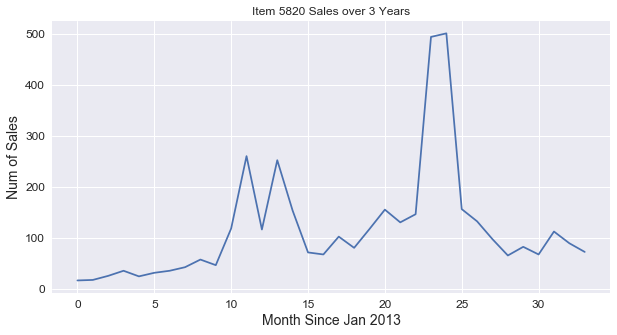

In [137]:
# plot the item 5820 sales over 3 years
plt.figure(figsize=(10,5))
plt.title('Item 5820 Sales over 3 Years')
plt.xlabel('Month Since Jan 2013')
plt.ylabel('Num of Sales')
plt.plot(df_item5820["date_block_num"],df_item5820["item_cnt_month"]);

In [138]:
df_item1741 = grouped_month_item[grouped_month_item['item_id'] == '1741']
df_item1741.head(10)

,date_block_num,item_id,item_cnt_month
3261,0,1741,22.0
11350,1,1741,26.0
19603,2,1741,19.0
27840,3,1741,22.0
36002,4,1741,15.0
44457,5,1741,23.0
52923,6,1741,30.0
61184,7,1741,33.0
69075,8,1741,19.0
77038,9,1741,16.0


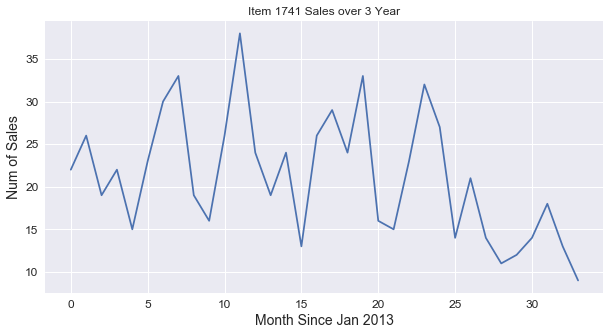

In [139]:
# plot the item 1741 sales over 3 years
plt.figure(figsize=(10,5))
plt.title('Item 1741 Sales over 3 Year')
plt.xlabel('Month Since Jan 2013')
plt.ylabel('Num of Sales')
plt.plot(df_item1741["date_block_num"],df_item1741["item_cnt_month"]);

After selecting most frequent 2 items, we cannot find a specific pattern.

## 2.2 Price change analysis

In [140]:
# create a sub dataframe 
df_work2 = new_train[['year','month','item_id','date_block_num','item_price']]
df_work2.head(10)

,year,month,item_id,date_block_num,item_price
0,2013,1,22154,0,999.00
1,2013,1,2552,0,899.00
2,2013,1,2552,0,899.00
3,2013,1,2554,0,1709.05
4,2013,1,2555,0,1099.00
5,2013,1,2564,0,349.00
6,2013,1,2565,0,549.00
7,2013,1,2572,0,239.00
8,2013,1,2572,0,299.00
9,2013,1,2573,0,299.00


In [141]:
grouped_mean_price = df_work2.groupby(['date_block_num', 'item_id']).agg({'item_price':'mean'}).reset_index().rename(columns = {"item_price":"item_month_mean"})
grouped_mean_price.head(10)

,date_block_num,item_id,item_month_mean
0,0,1000,89.060606
1,0,10000,499.000000
2,0,10004,149.000000
3,0,10008,135.727273
4,0,1001,90.800000
5,0,10010,541.250000
6,0,10012,144.133333
7,0,10014,28.000000
8,0,10017,98.000000
9,0,10018,149.000000


In [142]:
df_item5820 = grouped_mean_price[grouped_mean_price['item_id'] == '5820']
df_item5820.head(10)

,date_block_num,item_id,item_month_mean
6409,0,5820,1939.250000
14567,1,5820,1981.625000
22860,2,5820,1982.980000
31061,3,5820,1979.044118
39328,4,5820,1990.666667
47789,5,5820,1990.016129
56223,6,5820,1985.024857
64378,7,5820,1989.476190
72181,8,5820,1976.964286
80294,9,5820,1998.987805


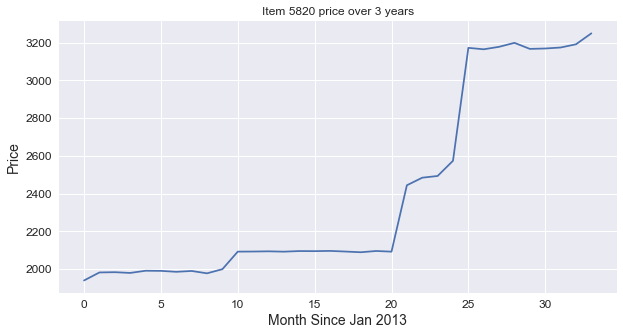

In [143]:
# plot the item 5820 price over 3 years
plt.figure(figsize=(10,5))
plt.title('Item 5820 price over 3 years')
plt.xlabel('Month Since Jan 2013')
plt.ylabel('Price')
plt.plot(df_item5820["date_block_num"],df_item5820["item_month_mean"]);

In [144]:
df_item1741 = grouped_mean_price[grouped_mean_price['item_id'] == '1741']
df_item1741.head(10)

,date_block_num,item_id,item_month_mean
3261,0,1741,299.000000
11350,1,1741,294.807692
19603,2,1741,293.263158
27840,3,1741,289.090909
36002,4,1741,291.733333
44457,5,1741,290.280000
52923,6,1741,288.100000
61184,7,1741,299.000000
69075,8,1741,293.263158
77038,9,1741,299.000000


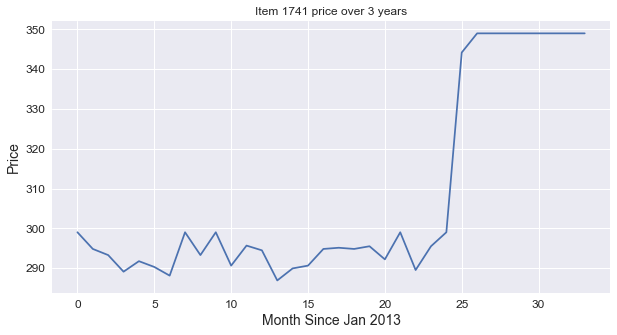

In [145]:
# plot the item 1741 price over 3 years
plt.figure(figsize=(10,5))
plt.title('Item 1741 price over 3 years')
plt.xlabel('Month Since Jan 2013')
plt.ylabel('Price')
plt.plot(df_item1741["date_block_num"],df_item1741["item_month_mean"]);

We can see the price varied from month to month. The price can go up or down. There is no explicit trend.

## 2.3 Price & sales analysis

Thr price and sales is highly likely to have a negative correlation.

In [146]:
# create a sub dataframe 
df_work3 = new_train[['item_id','item_cnt_day','item_price']]
df_work3.head(10)

,item_id,item_cnt_day,item_price
0,22154,1.0,999.00
1,2552,1.0,899.00
2,2552,-1.0,899.00
3,2554,1.0,1709.05
4,2555,1.0,1099.00
5,2564,1.0,349.00
6,2565,1.0,549.00
7,2572,1.0,239.00
8,2572,1.0,299.00
9,2573,3.0,299.00


In [147]:
grouped_count_price = df_work3.groupby(['item_id','item_price']).agg(np.sum).reset_index().rename(columns = {'item_cnt_day':'item_cnt_price'})
grouped_count_price.head(15)

,item_id,item_price,item_cnt_price
0,0,58.0,1.0
1,1,4490.0,6.0
2,10,28.0,1.0
3,100,76.0,4.0
4,100,79.0,3.0
5,100,149.0,58.0
6,1000,28.0,2.0
7,1000,58.0,41.0
8,1000,69.0,43.0
9,1000,79.0,1.0


Let's see how sales change according to prices for item 5820 and 1741

In [148]:
df_item1741 = grouped_count_price[grouped_count_price['item_id'] == '1741']
df_item1741.head()

,item_id,item_price,item_cnt_price
43573,1741,190.00,28.0
43574,1741,284.05,1.0
43575,1741,298.70,1.0
43576,1741,299.00,565.0
43577,1741,331.55,1.0


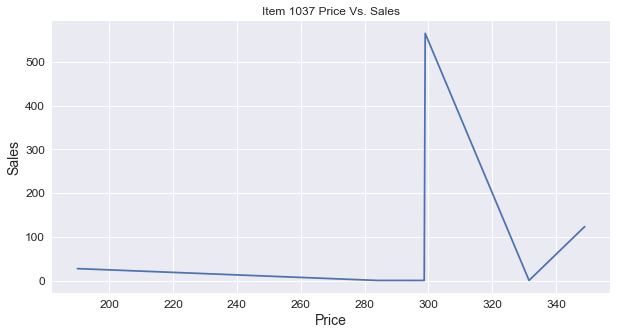

In [149]:
# plot the item 1741 price vs sales over 3 years
plt.figure(figsize=(10,5))
plt.title('Item 1037 Price Vs. Sales')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.plot(df_item1741["item_price"],df_item1741["item_cnt_price"])

In [150]:
df_item5820 = grouped_count_price[grouped_count_price['item_id'] == '5820']
df_item5820.head()

,item_id,item_price,item_cnt_price
96086,5820,1599.0,4.0
96087,5820,1678.4,1.0
96088,5820,1679.0,1.0
96089,5820,1721.0,10.0
96090,5820,1784.0,1.0


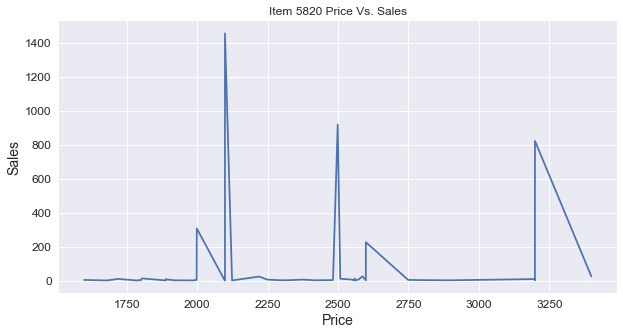

In [151]:
# plot the item 5820 price vs sales over 3 years
plt.figure(figsize=(10,5))
plt.title('Item 5820 Price Vs. Sales')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.plot(df_item5820["item_price"],df_item5820["item_cnt_price"])

We can conclude that the prices don't necessarily affect the sales.

# 3. Feature Selection

In [152]:
new_train.head()

,date,year,month,day,Day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,Is_holiday,Is_holiday(binary)
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",False,0
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
2,2013-01-05,2013,1,5,5,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False,0
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",False,0


Create a pivot table, group by shop_id and item_id, sum by date_block_num

In [153]:
pivot_df_1 = new_train.pivot_table(index=['shop_id','item_id'], 
                            columns='date_block_num', 
                            values='item_cnt_day',
                            aggfunc='sum').fillna(0.0)
pivot_df_1 = pivot_df_1.reset_index()

In [154]:
pivot_df_1.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,1000,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,10004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1001,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,10012,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1002,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
def update_columns(df,arg):
    col = df.columns.tolist()
    update_col = {}
    for item in col:
        if type(item) == int:
            update_col[item] = arg + ' in ' + str(item) 
        else:
            update_col[item] = item
    df = df.rename(columns = update_col)
    return df

In [156]:
pivot_df_1 = update_columns(pivot_df_1,'sales')

In [157]:
pivot_df_2 = new_train.pivot_table(index=['shop_id','item_id'], 
                            columns='date_block_num', 
                            values='Is_holiday(binary)',
                            aggfunc='sum').fillna(0.0)
pivot_df_2 = pivot_df_2.reset_index()

In [158]:
pivot_df_2 = update_columns(pivot_df_2,'Is_holiday_sales')

In [159]:
pivot_df_3 = new_train.pivot_table(index=['shop_id','item_id'], 
                            columns='date_block_num', 
                            values='item_price',
                            aggfunc='mean').fillna(0.0)
pivot_df_3 = pivot_df_3.reset_index()

In [160]:
pivot_df_3 = update_columns(pivot_df_3,'Avg_Price')

In [161]:
pivot_df_3.head()

date_block_num,shop_id,item_id,Avg_Price in 0,Avg_Price in 1,Avg_Price in 2,Avg_Price in 3,Avg_Price in 4,Avg_Price in 5,Avg_Price in 6,Avg_Price in 7,...,Avg_Price in 24,Avg_Price in 25,Avg_Price in 26,Avg_Price in 27,Avg_Price in 28,Avg_Price in 29,Avg_Price in 30,Avg_Price in 31,Avg_Price in 32,Avg_Price in 33
0,0,1000,58.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,10004,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1001,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,10012,76.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1002,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
pivot_df_3.shape

(424124, 36)

In [163]:
train_df = pd.merge(pivot_df_2,pivot_df_1, how ='inner', on = ['shop_id', 'item_id'])

In [164]:
train_df.head()

date_block_num,shop_id,item_id,Is_holiday_sales in 0,Is_holiday_sales in 1,Is_holiday_sales in 2,Is_holiday_sales in 3,Is_holiday_sales in 4,Is_holiday_sales in 5,Is_holiday_sales in 6,Is_holiday_sales in 7,...,sales in 24,sales in 25,sales in 26,sales in 27,sales in 28,sales in 29,sales in 30,sales in 31,sales in 32,sales in 33
0,0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,10012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
train_df = pivot_df_3.merge(train_df, how ='inner', on = ['shop_id', 'item_id'])

In [166]:
train = new_train[['shop_id', 'item_id','item_category_id']].merge(train_df, how = 'inner', on = ['shop_id', 'item_id'])

In [167]:
train = train.drop_duplicates(['shop_id','item_id'])

In [168]:
train.head()

,shop_id,item_id,item_category_id,Avg_Price in 0,Avg_Price in 1,Avg_Price in 2,Avg_Price in 3,Avg_Price in 4,Avg_Price in 5,Avg_Price in 6,...,sales in 24,sales in 25,sales in 26,sales in 27,sales in 28,sales in 29,sales in 30,sales in 31,sales in 32,sales in 33
0,59,22154,37,999.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,2552,58,899.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25,2554,58,1709.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25,2555,56,1099.00,1099.0,1099.0,1099.0,0.0,1099.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,25,2564,59,349.00,0.0,0.0,0.0,349.0,0.0,349.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
train.shape

(424124, 105)

# 4. Model implementation 

The following session will use XGBoot, LGBM and other algorithms to train the model in order to get the best results.

##  xgboost

In [180]:
X_train = train.iloc[:, :-1].values
print(X_train.shape)

(424124, 104)


In [171]:
# Create target to predict
y_train = train.iloc[:, -1].values
print(y_train.shape)

(424124,)


In [172]:
param = {'max_depth':20,  # originally 10
         'subsample':1,  # 1
         'min_child_weight':0.5,  # 0.5
         'eta':0.3,
         'num_round':1000, 
         'seed':0,  # 1
         'silent':0,
         'eval_metric':'rmse',
         'early_stopping_rounds':100
        }

progress = dict()
xgbtrain = xgb.DMatrix(X_train, y_train)
watchlist  = [(xgbtrain,'train-rmse')]
bst = xgb.train(param, xgbtrain)

In [173]:
# Get predictions and rmse score
from sklearn.metrics import mean_squared_error 
preds = bst.predict(xgb.DMatrix(X_train))

rmse = np.sqrt(mean_squared_error(preds, y_train))
print(rmse)

0.775116682483805


# 5. Testing

In [174]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [176]:
# Convert values to string
test['shop_id']= test.shop_id.astype('str')
test['item_id']= test.item_id.astype('str')

# Merge the monthly item count data
test = test.merge(train, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
test.head()

,ID,shop_id,item_id,item_category_id,Avg_Price in 0,Avg_Price in 1,Avg_Price in 2,Avg_Price in 3,Avg_Price in 4,Avg_Price in 5,...,sales in 24,sales in 25,sales in 26,sales in 27,sales in 28,sales in 29,sales in 30,sales in 31,sales in 32,sales in 33
0,0,5,5037,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
X_test = test.drop(['ID','sales in 33'], axis=1).values
print(X_test.shape)

(214200, 104)


In [183]:
preds = bst.predict(xgb.DMatrix(X_test))
print(preds.shape)

(214200,)


In [185]:
# Clip to values 0 - 20 and create submission file
sub_df = pd.DataFrame({'ID':test.ID, 'item_cnt_month': preds.clip(0. ,20.)})
sub_df.to_csv('submission.csv',index=False)